# Logisitic smooth regression model

Following van der Wiel et al. 2019, let's model energy demand using a logistic smooth regression model: https://www.sciencedirect.com/science/article/pii/S1364032119302862

This takes a single predictor, daily mean temperature, and provides a smooth transition between two linear regimes.

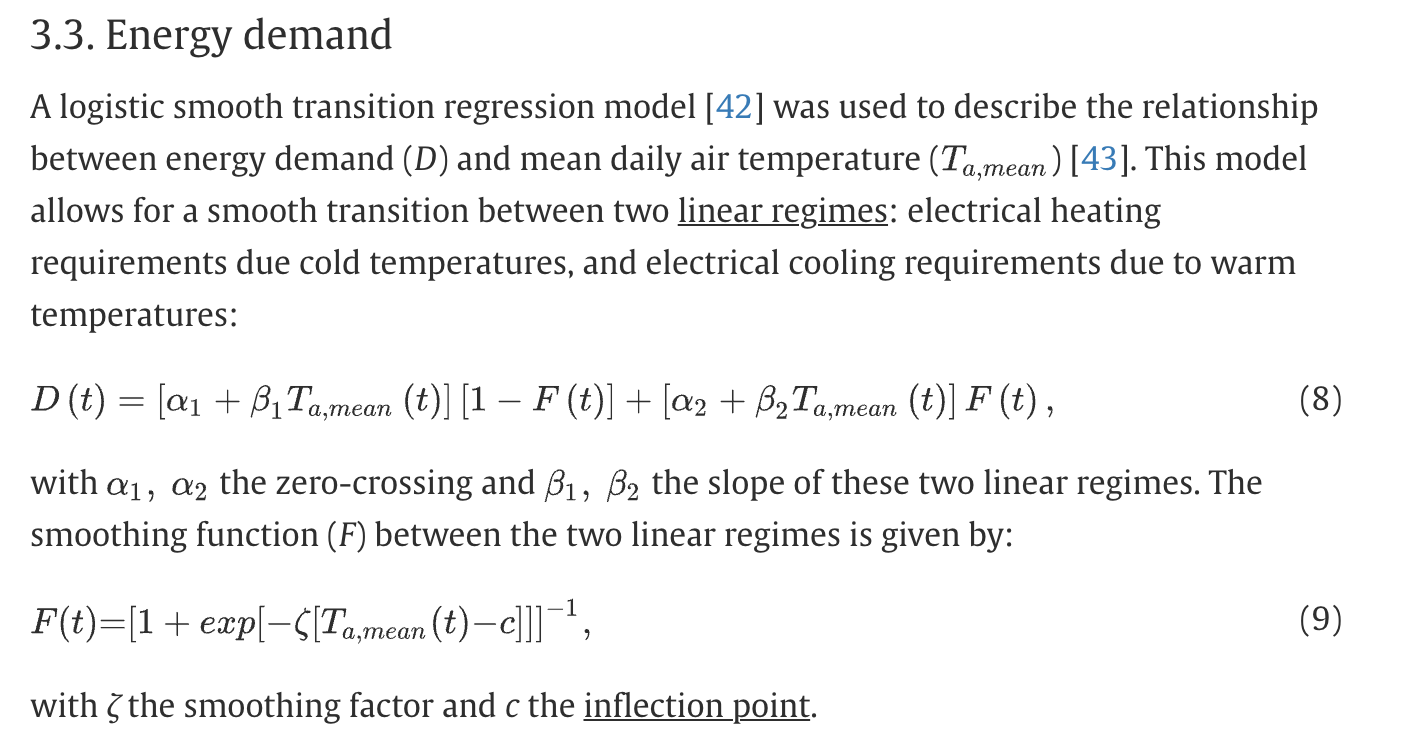

In [103]:
import xarray as xr
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

In [2]:
path = "/g/data/w42/dr6273/work/projects/Aus_energy/"

# Load predictors and predictands

Detrended energy demand (predictand)

In [3]:
dem_da = xr.open_dataset(
    path + "/data/energy_demand/daily_demand_2010-2020_detrended.nc"
)["demand_dt"]

Daily mean temperature

In [6]:
t2m = xr.open_dataset(path + "demand_predictors/2t_era5_daily_1959-2022_NEM.nc")["t2m"]

# Plot demand versus temperature

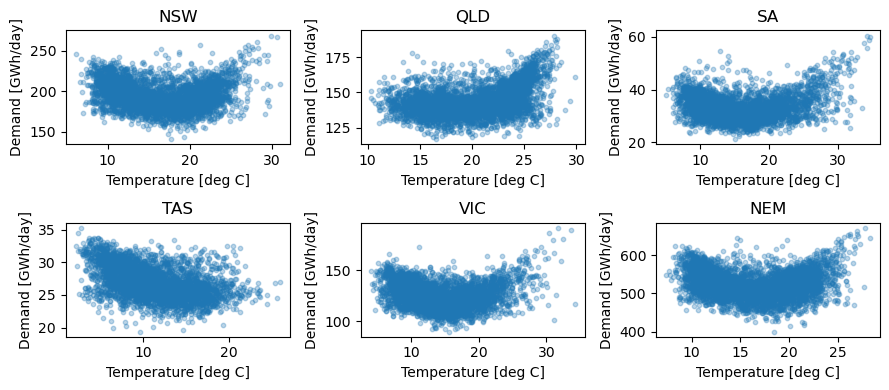

In [17]:
fig, ax = plt.subplots(2, 3, figsize=(9,4))
for i, region in enumerate(dem_da["region"].values):
    a = ax.flatten()[i]
    a.scatter(
        t2m.sel(region=region, time=dem_da["time"]) - 273.15,
        dem_da.sel(region=region) / 1000,
        alpha=0.3,
        s=10
    )
    a.set_xlabel("Temperature [deg C]")
    a.set_ylabel("Demand [GWh/day]")
    a.set_title(region)
plt.tight_layout()

# Try using `scipy` `curve_fit`

In [144]:
from scipy.optimize import curve_fit

In [143]:
def lstr(x, a1, a2, b1, b2, z, c):
    """
    Logistic smooth transition equation
    """
    F = 1 / (1 + np.exp(-z * (x - c)))
    term1 = (a1 + b1 * x) * (1 - F)
    term2 = (a2 + b2 * x) * F
    return term1 + term2

In [167]:
x = t2m.sel(region="NEM", time=dem_da.time).values

In [168]:
y = dem_da.sel(region="NEM").values

In [169]:
# def objective(x, a, b):
#     return a * x + b

Need to guess starting parameter values otherwise fitting will fail

In [222]:
init = [6e5, 6e5, 0, 0, 1, 2]

In [223]:
params, _ = curve_fit(lstr, x, y, p0=init)
a1, a2, b1, b2, z, c = params
x_line = np.arange(min(x), max(x), 1)
y_line = lstr(x_line, a1, a2, b1, b2, z, c)

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [220]:
1e4

10000.0

In [221]:
np.diff(y[np.argsort(x)][1000:])

array([  11024.9226736 ,   28386.81266154,  -85047.83384299, ...,
       -111905.47087682,  154510.77164857,  -25642.74010507])

In [224]:
print(params)

[ 6.0000000e+05  6.8247099e+05  0.0000000e+00 -5.4018454e+02
  1.0000000e+00  2.0000000e+00]


In [199]:
# params, _ = curve_fit(objective, x, y)
# a, b = params
# x_line = np.arange(min(x), max(x), 1)
# y_line = objective(x_line, a, b)

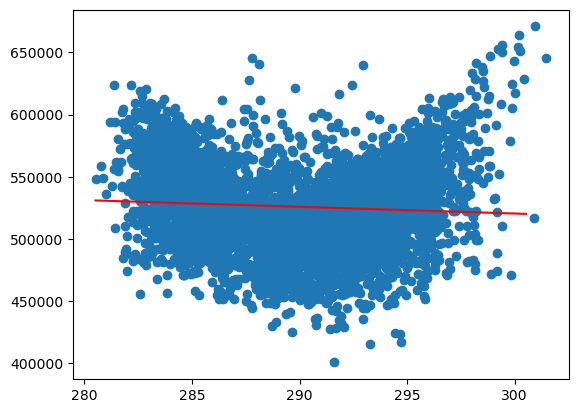

In [200]:
plt.scatter(x, y)
plt.plot(x_line, y_line, color="r")

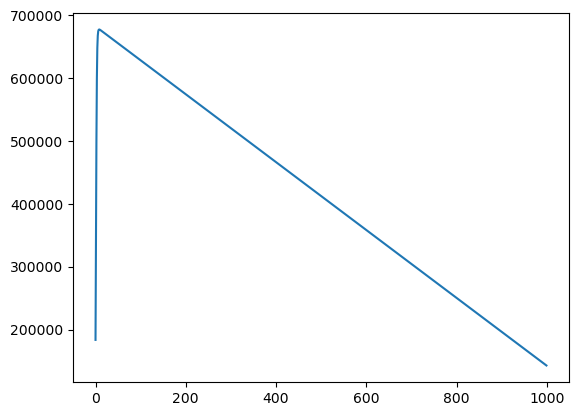

In [166]:
plt.plot(y)
# plt.plot(lstr(x, a1, a2, b1, b2, z, c))

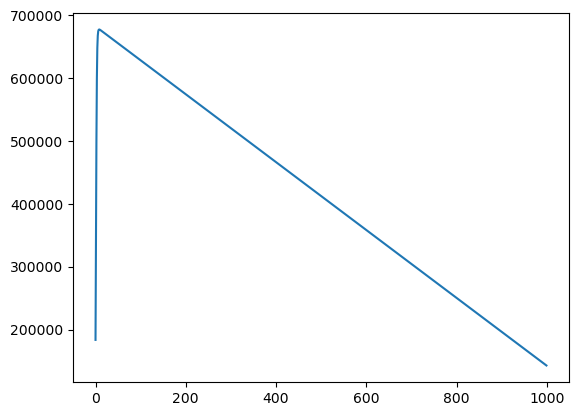

In [153]:
x = np.arange(1000)
y = lstr(x, a1, a2, b1, b2, z, c)
plt.plot(x, y)

In [79]:
from scipy.stats import pearsonr

In [80]:
pearsonr(y, y_line)

(0.06544987716709215, 3.305039019835143e-05)